In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List
import math
from torch.utils.data import TensorDataset, DataLoader


class CausalDiscoveryLayer(nn.Module):
    """
    Lop hoc do thi nhan qua toi uu, gian luoc de chay nhanh.
    """
    def __init__(self, num_variables: int, hidden_dim: int = 32):
        super().__init__()
        self.num_variables = num_variables
        self.hidden_dim = hidden_dim
        self.causal_logits = nn.Parameter(torch.randn(num_variables, num_variables) * 0.1)
        self.causal_transform = nn.Sequential(
            nn.Linear(num_variables, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_variables)
        )

    def get_causal_adjacency(self, temperature=0.7, hard=False):
        scaled_logits = self.causal_logits / float(temperature)

        masked_logits = scaled_logits.clone()
        eye = torch.eye(self.num_variables, device=scaled_logits.device).bool()
        masked_logits = masked_logits.masked_fill(eye, float('-inf'))

        causal_probs = torch.sigmoid(masked_logits)

        causal_probs = causal_probs * (~eye).float()

        if hard:
            return (causal_probs > 0.5).float()
        return causal_probs


    def apply_causal_mask(self, x, causal_adj):
        batch_size, seq_len, _ = x.shape
        causal_features = torch.zeros_like(x)
        for t in range(1, seq_len):
            prev_features = x[:, t-1, :]  # [B, V]
            for i in range(self.num_variables):
                parents = causal_adj[:, i]             # [V]
                causal_influence = torch.sum(prev_features * parents.unsqueeze(0), dim=1)
                causal_features[:, t, i] = causal_influence
        causal_features[:, 0, :] = x[:, 0, :]
        return causal_features

    def forward(self, x):
        # x: [B, T, V]
        causal_adj = self.get_causal_adjacency()
        causal_features = self.apply_causal_mask(x, causal_adj)
        B, T, V = x.shape
        enhanced = torch.zeros_like(causal_features)
        for t in range(T):
            enhanced[:, t, :] = self.causal_transform(causal_features[:, t, :])
        return causal_adj, enhanced


class CausalAttention(nn.Module):
    """
    Self-attention co mask nhan qua thoi gian (khong nhin tuong lai).
    """
    def __init__(self, d_model: int, num_heads: int = 4):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        assert d_model % num_heads == 0
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, causal_adj=None, mask=None):
        B, T, _ = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        temporal_mask = torch.tril(torch.ones(T, T, device=x.device))
        scores = scores.masked_fill(temporal_mask.unsqueeze(0).unsqueeze(0) == 0, -1e9)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.matmul(attn, v)  # [B, H, T, Hd]
        out = out.transpose(1, 2).contiguous().view(B, T, self.d_model)
        return self.out_proj(out), attn


class CausalTransformerBlock(nn.Module):
    """
    1 block Transformer: CausalAttention + FFN
    """
    def __init__(self, d_model: int, num_heads: int, ff_dim: int, dropout: float = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, causal_adj, mask=None):
        attn_out, attn_w = self.causal_attention(x, causal_adj, mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.feedforward(x)
        x = self.norm2(x + ff_out)
        return x, attn_w


class CausalDiscoveryTransformer(nn.Module):
    """
    Mo hinh CD-Transformer toi uu cho du bao gia co phieu.
    """
    def __init__(
        self,
        num_variables: int,
        d_model: int = 64,
        num_heads: int = 4,
        num_layers: int = 2,
        ff_dim: int = 128,
        max_seq_len: int = 50,
        dropout: float = 0.1,
        prediction_horizon: int = 1
    ):
        super().__init__()
        self.num_variables = num_variables
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.prediction_horizon = prediction_horizon

        self.causal_discovery = CausalDiscoveryLayer(num_variables)
        self.input_projection = nn.Linear(num_variables, d_model)
        self.positional_encoding = self._create_positional_encoding(max_seq_len, d_model)

        self.transformer_layers = nn.ModuleList([
            CausalTransformerBlock(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        self.output_projection = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, prediction_horizon)
        )

        self.intervention_adapter = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Linear(d_model // 2, d_model)
        )

        self.dropout = nn.Dropout(dropout)

    def _create_positional_encoding(self, max_len: int, d_model: int):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-(math.log(10000.0) / d_model)))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x, intervention_mask=None):
        B, T, _ = x.shape
        causal_adj, causal_features = self.causal_discovery(x)
        enhanced = 0.5 * x + 0.5 * causal_features

        x_emb = self.input_projection(enhanced)
        pos = self.positional_encoding[:, :T, :].to(x.device)
        x_emb = self.dropout(x_emb + pos)

        if intervention_mask is not None:
            inter_eff = self.intervention_adapter(x_emb)
            x_emb = x_emb + intervention_mask.unsqueeze(-1) * inter_eff * 0.1

        attn_list = []
        for layer in self.transformer_layers:
            x_emb, attn_w = layer(x_emb, causal_adj)
            attn_list.append(attn_w)

        last = x_emb[:, -1, :]
        preds = self.output_projection(last)
        return preds, causal_adj, attn_list

    def compute_causal_loss(self, causal_adj):
        sparsity_loss = torch.mean(causal_adj)
        consistency_loss = torch.var(causal_adj)
        dag_loss = torch.trace(causal_adj @ causal_adj) / self.num_variables
        return dag_loss, sparsity_loss, consistency_loss

    def intervention_robustness_loss(self, predictions_original, predictions_intervened):
        return F.mse_loss(predictions_original, predictions_intervened)


class StockPriceCausalPredictor:
    """
    Wrapper huan luyen/suy luan cho CD-Transformer
    """
    def __init__(
        self,
        feature_names: List[str],
        d_model: int = 64,
        num_heads: int = 4,
        num_layers: int = 2,
        prediction_horizon: int = 1,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        sparsity_weight: float = 0.05
    ):
        self.feature_names = feature_names
        self.num_variables = len(feature_names)
        self.device = device

        self.model = CausalDiscoveryTransformer(
            num_variables=self.num_variables,
            d_model=d_model,
            num_heads=num_heads,
            num_layers=num_layers,
            prediction_horizon=prediction_horizon
        ).to(device)

        self.prediction_weight = 1.0
        self.dag_weight = 0.05
        self.sparsity_weight = float(sparsity_weight)
        self.consistency_weight = 0.01
        self.intervention_weight = 0.02

    def set_loss_weights(self, **kw):
        for k, v in kw.items():
            if hasattr(self, f"{k}_weight"):
                setattr(self, f"{k}_weight", float(v))

    def train_step(self, batch_data, optimizer):
        self.model.train()
        optimizer.zero_grad()

        x, y_true = batch_data
        x, y_true = x.to(self.device), y_true.to(self.device)

        predictions, causal_adj, _ = self.model(x)
        prediction_loss = F.mse_loss(predictions, y_true)
        dag_loss, sparsity_loss, consistency_loss = self.model.compute_causal_loss(causal_adj)

        intervention_loss = 0.0
        if torch.rand(1).item() > 0.7:
            var_idx = torch.randint(0, self.num_variables, (1,)).item()
            intervention_mask = torch.ones_like(x[:, :, 0])
            predictions_intervened, _, _ = self.model(x, intervention_mask)
            intervention_loss = self.model.intervention_robustness_loss(predictions, predictions_intervened)

        total_loss = (
            self.prediction_weight * prediction_loss +
            self.dag_weight * dag_loss +
            self.sparsity_weight * sparsity_loss +
            self.consistency_weight * consistency_loss +
            self.intervention_weight * intervention_loss
        )

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        optimizer.step()

        return {
            'total_loss': float(total_loss.detach().cpu().item()),
            'prediction_loss': float(prediction_loss.detach().cpu().item()),
            'dag_loss': float(dag_loss.detach().cpu().item()),
            'sparsity_loss': float(sparsity_loss.detach().cpu().item()),
            'consistency_loss': float(consistency_loss.detach().cpu().item()),
            'intervention_loss': float(intervention_loss if isinstance(intervention_loss, float) else intervention_loss.detach().cpu().item())
        }

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32).to(self.device)
            if len(x.shape) == 2:
                x = x.unsqueeze(0)
            predictions, causal_adj, attention_weights = self.model(x)
            return {
                'predictions': predictions.cpu().numpy(),
                'causal_structure': causal_adj.cpu().numpy(),
                'attention_weights': [w.cpu().numpy() for w in attention_weights]
            }

    def get_causal_relationships(self, threshold: float = 0.3, temperature: float = 0.7):
        self.model.eval()
        with torch.no_grad():
            causal_adj = self.model.causal_discovery.get_causal_adjacency(
                temperature=temperature, hard=False
            ).cpu().numpy()

            rel = []
            V = self.num_variables
            for i in range(V):
                for j in range(V):
                    if i == j:
                        continue
                    strength = float(causal_adj[i, j])
                    if strength >= threshold:
                        rel.append({
                            'cause': self.feature_names[i],
                            'effect': self.feature_names[j],
                            'strength': strength,
                            'description': f"{self.feature_names[i]} -> {self.feature_names[j]}"
                        })
            rel.sort(key=lambda x: x['strength'], reverse=True)
            return rel


    def test_intervention_robustness(self, X_test, num_samples=20):
        self.model.eval()
        with torch.no_grad():
            Xt = torch.tensor(X_test[:num_samples], dtype=torch.float32).to(self.device)
            base_pred, _, _ = self.model(Xt)
            base_pred = base_pred.cpu().numpy()

        effects = {}
        for i, fname in enumerate(self.feature_names):
            vals = []
            for iv in [-1.0, 0.0, 1.0]:
                X_int = X_test[:num_samples].copy()
                X_int[:, :, i] = iv
                with torch.no_grad():
                    Xt_i = torch.tensor(X_int, dtype=torch.float32).to(self.device)
                    p_i, _, _ = self.model(Xt_i)
                    p_i = p_i.cpu().numpy()
                    vals.append(np.mean(np.abs(base_pred - p_i)))
            effects[fname] = float(np.mean(vals))
        return effects

class SparsityScheduler:
    """
    Cosine ramp cho sparsity_weight theo epoch: start -> end trong T epochs.
    start < end: tang dan. Muon giam dan thi dao start > end.
    """
    def __init__(self, model_wrapper, start=0.03, end=0.08, T=25):
        self.model_wrapper = model_wrapper
        self.start = float(start)
        self.end = float(end)
        self.T = int(T)
        self.t = 0

    def step(self):
        import numpy as np
        cosv = 0.5 * (1 - np.cos(np.pi * min(self.t, self.T) / self.T))
        self.model_wrapper.sparsity_weight = float(self.start + (self.end - self.start) * cosv)
        self.t += 1


def suggest_sparsity_weight(n_months: int,
                            base: float = 0.10,
                            ref_months: int = 24,
                            floor: float = 0.03,
                            ceil: float = 0.12) -> float:
    """
    Go y sparsity theo do dai thoi gian (thang):
    w = base * (ref / n_months), chan trong [floor, ceil]
    2y ~ 24m: ~0.10
    5y ~ 60m: ~0.04-0.05
    10y ~ 120m: ~0.03-0.04
    """
    w = base * (ref_months / max(int(n_months), 1))
    return float(np.clip(w, floor, ceil))

def make_time_windows(X, win_len_months, step_months, samples_per_month: int):
    """
    Tao danh sach (start, end) theo chi so mau sau khi da window hoa chuoi.
    X: numpy array (N, T, V)
    """
    win = int(win_len_months * samples_per_month)
    step = int(step_months * samples_per_month)
    idx = []
    s = 0
    while s + win <= len(X):
        idx.append((s, s + win))
        s += step
    return idx


def build_loader(X_np, y_np, batch_size=32, shuffle=True):
    ds = TensorDataset(
        torch.tensor(X_np, dtype=torch.float32),
        torch.tensor(y_np, dtype=torch.float32)
    )
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)


def train_sliding_windows(
    X, y, feature_names,
    win_len_months=24, step_months=6, samples_per_month=21,
    num_epochs=20, batch_size=32,
    d_model=64, num_heads=4, num_layers=2, prediction_horizon=1,
    base_sparsity_base=0.10, ref_months=24,
    device=None
):
    """
    Train nhieu cua so thoi gian, hop nhat causal graph on windows.
    Tra ve: danh sach causal_adj theo tung cua so, edge_freq, stable_graph
    """
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    win_idx = make_time_windows(X, win_len_months, step_months, samples_per_month)

    all_adj = []
    for k, (s, e) in enumerate(win_idx):
        print(f"[Window {k+1}/{len(win_idx)}] samples [{s}:{e})")

        spw = suggest_sparsity_weight(
            n_months=win_len_months,
            base=base_sparsity_base,
            ref_months=ref_months,
            floor=0.03,
            ceil=0.12
        )

        model = StockPriceCausalPredictor(
            feature_names=feature_names,
            d_model=d_model, num_heads=num_heads, num_layers=num_layers,
            prediction_horizon=prediction_horizon,
            device=device,
            sparsity_weight=spw
        )

        opt = torch.optim.AdamW(model.model.parameters(), lr=1e-3, weight_decay=1e-2)
        sch_lr = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs, eta_min=1e-5)

        train_loader = build_loader(X[s:e], y[s:e], batch_size=batch_size, shuffle=True)

        sch_sp = SparsityScheduler(model, start=spw*0.8, end=spw*1.2, T=num_epochs)

        for ep in range(num_epochs):
            for xb, yb in train_loader:
                logs = model.train_step((xb, yb), opt)
            sch_sp.step()
            sch_lr.step()

        model.model.eval()
        with torch.no_grad():
            x_probe = torch.tensor(X[s:e][:min(64, e-s)], dtype=torch.float32).to(device)
            _, causal_adj, _ = model.model(x_probe)
            all_adj.append(causal_adj.cpu().numpy())

    A = np.stack(all_adj, axis=0)
    edge_mean = A.mean(axis=0)
    MEAN_THRESH = 0.35
    stable_graph_mean = (edge_mean >= MEAN_THRESH).astype(float)

    BIN_THRESH = 0.40
    A_bin = (A > BIN_THRESH).astype(float)
    edge_freq = A_bin.mean(axis=0)
    FREQ_THRESH = 0.50
    stable_graph_freq = (edge_freq >= FREQ_THRESH).astype(float)


    return all_adj, edge_mean, edge_freq, stable_graph_mean, stable_graph_freq


if __name__ == "__main__":
    N, T, V = 1000, 30, 6
    np.random.seed(0)
    X = np.random.randn(N, T, V).astype(np.float32)
    y = np.random.randn(N, 1).astype(np.float32)
    feature_names = [f"feat_{i}" for i in range(V)]

    all_adj, edge_mean, edge_freq, stable_graph_mean, stable_graph_freq = train_sliding_windows(
        X, y, feature_names,
        win_len_months=24, step_months=6, samples_per_month=21,
        num_epochs=10, batch_size=32,
        d_model=64, num_heads=4, num_layers=2, prediction_horizon=1,
        base_sparsity_base=0.10, ref_months=24
    )

    print("So cua so:", len(all_adj))
    print("Edge mean shape:", edge_mean.shape)
    print("Stable edges by mean (>= 0.35):", int(stable_graph_mean.sum()))
    print("Edge freq shape:", edge_freq.shape)
    print("Stable edges by freq (bin>0.40, freq>=0.50):", int(stable_graph_freq.sum()))



[Window 1/4] samples [0:504)
[Window 2/4] samples [126:630)
[Window 3/4] samples [252:756)
[Window 4/4] samples [378:882)
So cua so: 4
Edge mean shape: (6, 6)
Stable edges by mean (>= 0.35): 30
Edge freq shape: (6, 6)
Stable edges by freq (bin>0.40, freq>=0.50): 30


Causal Discovery-Enhanced Transformer for Stock Prediction
Fetching stock data for AAPL...
Data shape: (453, 10)
Features: ['Close', 'Volume', 'Returns', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower', 'Volatility', 'Price_MA_20', 'Price_MA_50']

Preparing data for training...
Sequences created: X=(423, 30, 10), y=(423, 1)

Initializing Optimized Causal Discovery Transformer...
Training model with optimized parameters...
Epoch 5/50, Loss: 0.1936, LR: 0.000905
Epoch 10/50, Loss: 0.1710, LR: 0.000658
Epoch 15/50, Loss: 0.1559, LR: 0.000352
Epoch 20/50, Loss: 0.1497, LR: 0.000105
Epoch 25/50, Loss: 0.1473, LR: 0.000010
Epoch 30/50, Loss: 0.1445, LR: 0.000105
Epoch 35/50, Loss: 0.1443, LR: 0.000352
Epoch 40/50, Loss: 0.1422, LR: 0.000658
Epoch 45/50, Loss: 0.1322, LR: 0.000905
Epoch 50/50, Loss: 0.1234, LR: 0.001000

Evaluating model...
Test MSE: 0.195636
Test MAE: 0.321209

Discovered Causal Relationships:
----------------------------------------

BB_Lower is influenced by:
  • MACD (strength: 0.5

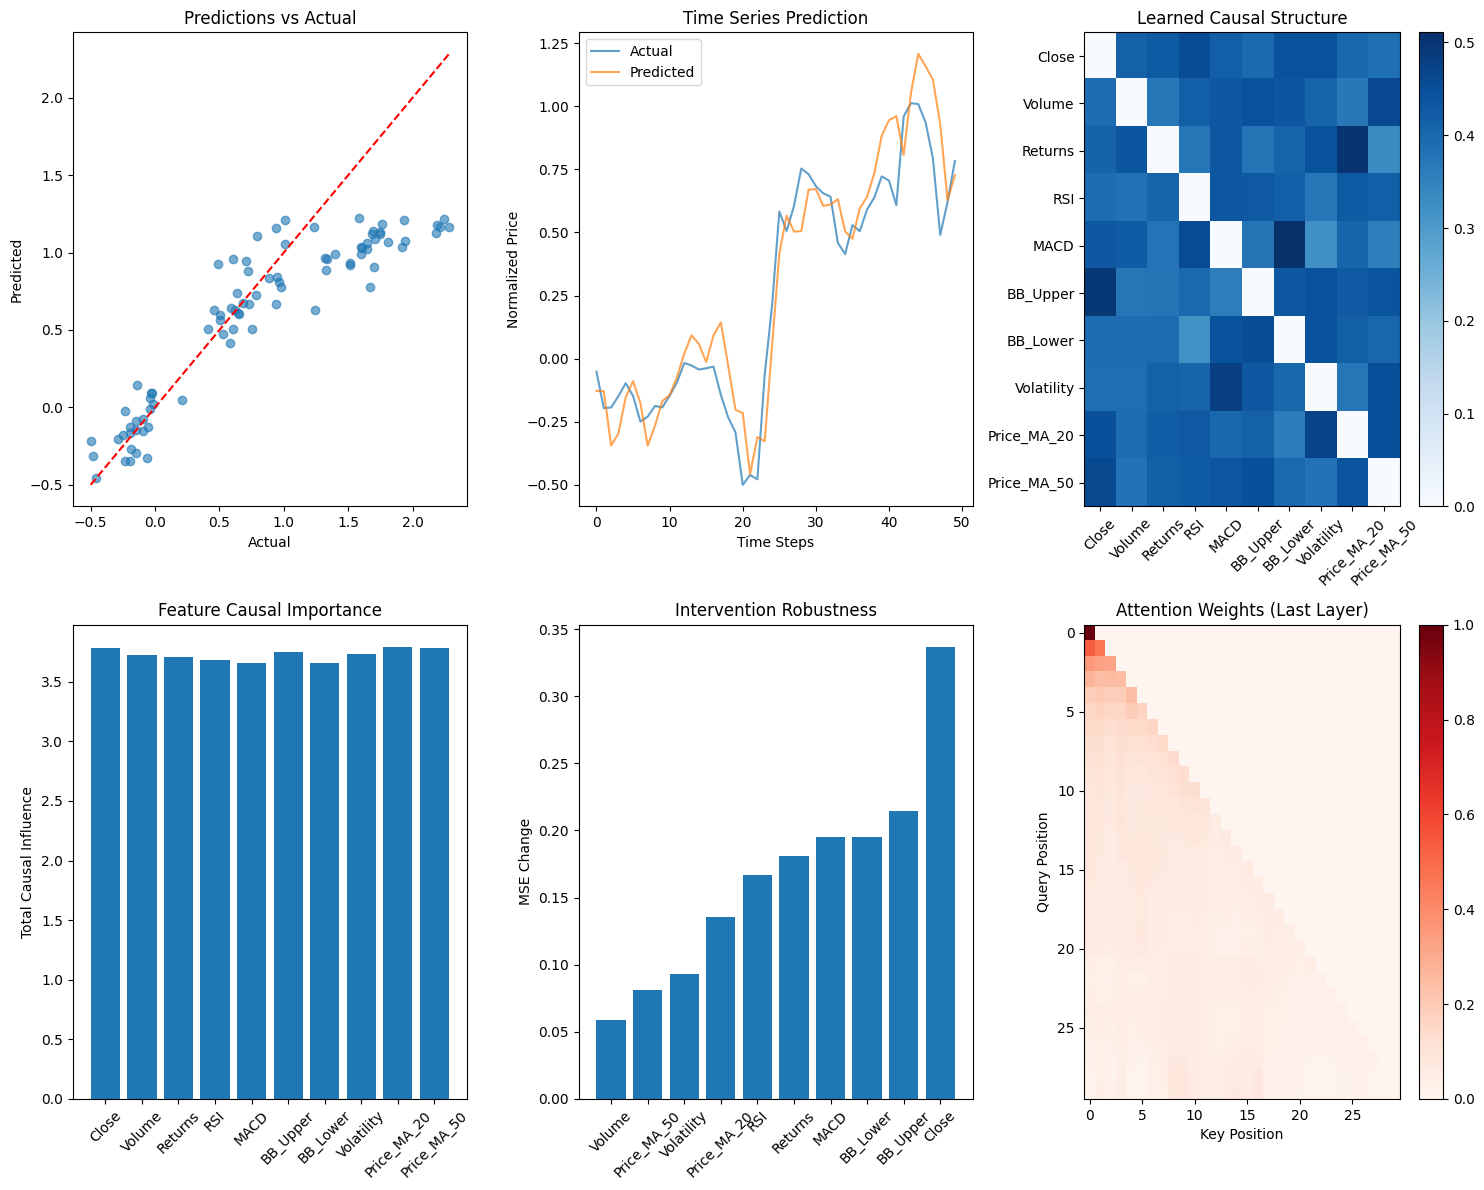


Analysis complete! Results saved to 'real_stock_causal_analysis.png'
Model saved as 'causal_stock_predictor.pth'


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def fetch_stock_data(symbol='AAPL', period='2y'):
    """Fetch real stock data and compute technical indicators."""

    # Download stock data
    stock = yf.Ticker(symbol)
    data = stock.history(period=period)

    # Calculate technical indicators
    data['Returns'] = data['Close'].pct_change()
    data['Volume_MA'] = data['Volume'].rolling(window=20).mean()
    data['Price_MA_20'] = data['Close'].rolling(window=20).mean()
    data['Price_MA_50'] = data['Close'].rolling(window=50).mean()

    # RSI calculation
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD calculation
    exp1 = data['Close'].ewm(span=12).mean()
    exp2 = data['Close'].ewm(span=26).mean()
    data['MACD'] = exp1 - exp2
    data['MACD_Signal'] = data['MACD'].ewm(span=9).mean()

    # Bollinger Bands
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    bb_std = data['Close'].rolling(window=20).std()
    data['BB_Upper'] = data['BB_Middle'] + (bb_std * 2)
    data['BB_Lower'] = data['BB_Middle'] - (bb_std * 2)

    # Volatility
    data['Volatility'] = data['Returns'].rolling(window=20).std()

    # Select features for the model
    features = [
        'Close', 'Volume', 'Returns', 'RSI', 'MACD',
        'BB_Upper', 'BB_Lower', 'Volatility', 'Price_MA_20', 'Price_MA_50'
    ]

    # Clean data
    feature_data = data[features].dropna()

    return feature_data, features

def prepare_data_for_model(data, seq_len=30, prediction_horizon=1):
    """Prepare data for the causal transformer."""

    # Normalize data
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)

    # Create sequences
    X, y = [], []
    for i in range(len(data_normalized) - seq_len - prediction_horizon + 1):
        X.append(data_normalized[i:i + seq_len])
        # Predict next day's closing price (first column)
        y.append(data_normalized[i + seq_len:i + seq_len + prediction_horizon, 0])

    return np.array(X), np.array(y), scaler

def analyze_causal_relationships(predictor, feature_names):
    """Analyze and visualize learned causal relationships."""

    relationships = predictor.get_causal_relationships(threshold=0.1)  # Lower threshold to see relationships

    print("Discovered Causal Relationships:")
    print("-" * 40)

    if not relationships:
        print("No relationships found at threshold 0.1, trying 0.05...")
        relationships = predictor.get_causal_relationships(threshold=0.05)

    if not relationships:
        print("No relationships found at threshold 0.05, trying 0.01...")
        relationships = predictor.get_causal_relationships(threshold=0.01)

    if relationships:
        # Group by effect variable
        causal_dict = {}
        for rel in relationships:
            effect = rel['effect']
            if effect not in causal_dict:
                causal_dict[effect] = []
            causal_dict[effect].append((rel['cause'], rel['strength']))

        for effect, causes in causal_dict.items():
            print(f"\n{effect} is influenced by:")
            causes.sort(key=lambda x: x[1], reverse=True)  # Sort by strength
            for cause, strength in causes[:5]:  # Show top 5 causes
                print(f"  • {cause} (strength: {strength:.3f})")

        print(f"\nTotal relationships discovered: {len(relationships)}")
    else:
        print("No causal relationships discovered. Model may need more training or different hyperparameters.")

    return relationships

def print_intervention_results(intervention_results):
    """Print intervention robustness results."""
    print("\nTesting Intervention Robustness:")
    print("-" * 40)

    for feature, effect in intervention_results.items():
        print(f"{feature}: Average effect = {effect:.6f}")

    # Features with low effect are likely non-causal for the target
    most_robust = min(intervention_results, key=intervention_results.get)
    least_robust = max(intervention_results, key=intervention_results.get)

    print(f"\nMost robust to intervention (likely non-causal): {most_robust}")
    print(f"Least robust to intervention (likely causal): {least_robust}")

    return intervention_results

def main():
    """Main demo function."""

    print("Causal Discovery-Enhanced Transformer for Stock Prediction")
    print("=" * 60)

    # Fetch real stock data
    print("Fetching stock data for AAPL...")
    stock_data, feature_names = fetch_stock_data('AAPL', period='2y')
    print(f"Data shape: {stock_data.shape}")
    print(f"Features: {feature_names}")

    # Prepare data
    print("\nPreparing data for training...")
    X, y, scaler = prepare_data_for_model(stock_data, seq_len=30, prediction_horizon=1)
    print(f"Sequences created: X={X.shape}, y={y.shape}")

    # Split data (use last 20% for testing)
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Initialize optimized model
    print("\nInitializing Optimized Causal Discovery Transformer...")
    predictor = StockPriceCausalPredictor(
        feature_names=feature_names,
        d_model=64,  # Reduced from 128
        num_heads=4,  # Reduced from 8
        num_layers=2,  # Reduced from 4
        prediction_horizon=1
    )

    # Optimized training setup
    print("Training model with optimized parameters...")
    optimizer = torch.optim.AdamW(predictor.model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-5)
    batch_size = 32  # Increased batch size
    num_epochs = 50  # Reduced epochs

    # Training with early stopping
    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(num_epochs):
        epoch_losses = []

        # Shuffle training data
        indices = np.random.permutation(len(X_train))

        # Mini-batch training
        for i in range(0, len(X_train), batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_x = torch.tensor(X_train[batch_indices], dtype=torch.float32)
            batch_y = torch.tensor(y_train[batch_indices], dtype=torch.float32)

            losses = predictor.train_step((batch_x, batch_y), optimizer)
            epoch_losses.append(losses['total_loss'])

        avg_loss = np.mean(epoch_losses)

        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Update learning rate
        scheduler.step()

        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

    # Evaluation
    print("\nEvaluating model...")
    test_results = predictor.predict(X_test)
    predictions = test_results['predictions'].flatten()

    # Calculate metrics
    mse = np.mean((predictions - y_test.flatten()) ** 2)
    mae = np.mean(np.abs(predictions - y_test.flatten()))

    print(f"Test MSE: {mse:.6f}")
    print(f"Test MAE: {mae:.6f}")

    # Analyze causal relationships
    print("\n" + "=" * 60)
    relationships = analyze_causal_relationships(predictor, feature_names)

    # Test intervention robustness
    print("\n" + "=" * 60)
    intervention_results = predictor.test_intervention_robustness(X_test, num_samples=20)
    print_intervention_results(intervention_results)

    # Visualizations
    plt.figure(figsize=(15, 12))

    # Plot 1: Predictions vs Actual
    plt.subplot(2, 3, 1)
    sample_size = min(100, len(predictions))
    plt.scatter(y_test.flatten()[:sample_size], predictions[:sample_size], alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predictions vs Actual')

    # Plot 2: Time series of predictions
    plt.subplot(2, 3, 2)
    time_range = range(min(50, len(predictions)))
    plt.plot(time_range, y_test.flatten()[:len(time_range)], label='Actual', alpha=0.7)
    plt.plot(time_range, predictions[:len(time_range)], label='Predicted', alpha=0.7)
    plt.legend()
    plt.title('Time Series Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Price')

    # Plot 3: Learned causal structure
    plt.subplot(2, 3, 3)
    causal_matrix = test_results['causal_structure']
    im = plt.imshow(causal_matrix, cmap='Blues', aspect='auto')
    plt.colorbar(im)
    plt.xticks(range(len(feature_names)), feature_names, rotation=45)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.title('Learned Causal Structure')

    # Plot 4: Feature causal importance
    plt.subplot(2, 3, 4)
    feature_importance = np.sum(causal_matrix, axis=1)
    plt.bar(range(len(feature_names)), feature_importance)
    plt.xticks(range(len(feature_names)), feature_names, rotation=45)
    plt.title('Feature Causal Importance')
    plt.ylabel('Total Causal Influence')

    # Plot 5: Intervention robustness
    plt.subplot(2, 3, 5)
    features_sorted = sorted(intervention_results.keys(), key=lambda x: intervention_results[x])
    values_sorted = [intervention_results[f] for f in features_sorted]
    plt.bar(range(len(features_sorted)), values_sorted)
    plt.xticks(range(len(features_sorted)), features_sorted, rotation=45)
    plt.title('Intervention Robustness')
    plt.ylabel('MSE Change')

    # Plot 6: Attention weights visualization (from last layer)
    plt.subplot(2, 3, 6)
    if test_results['attention_weights']:
        # Average attention weights across heads and batch
        attn_weights = test_results['attention_weights'][-1]  # Last layer
        avg_attn = np.mean(attn_weights[0], axis=0)  # First sample, average across heads

        im = plt.imshow(avg_attn, cmap='Reds', aspect='auto')
        plt.colorbar(im)
        plt.title('Attention Weights (Last Layer)')
        plt.xlabel('Key Position')
        plt.ylabel('Query Position')

    plt.tight_layout()
    plt.savefig('real_stock_causal_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nAnalysis complete! Results saved to 'real_stock_causal_analysis.png'")

    # Save model
    torch.save(predictor.model.state_dict(), 'causal_stock_predictor.pth')
    print("Model saved as 'causal_stock_predictor.pth'")

if __name__ == "__main__":
    main()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torch.utils.data import TensorDataset, DataLoader

class CausalDiscoveryLayer(nn.Module):
    def __init__(self, num_variables: int, hidden_dim: int = 32):
        super().__init__()
        self.num_variables = num_variables
        self.hidden_dim = hidden_dim
        self.causal_logits = nn.Parameter(torch.randn(num_variables, num_variables) * 0.1)
        self.causal_transform = nn.Sequential(
            nn.Linear(num_variables, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_variables)
        )

    def get_causal_adjacency(self, temperature=0.7, hard=False):
        scaled_logits = self.causal_logits / float(temperature)
        masked_logits = scaled_logits.clone()
        eye = torch.eye(self.num_variables, device=scaled_logits.device).bool()
        masked_logits = masked_logits.masked_fill(eye, float('-inf'))
        causal_probs = torch.sigmoid(masked_logits)
        causal_probs = causal_probs * (~eye).float()
        if hard: return (causal_probs > 0.5).float()
        return causal_probs

    def apply_causal_mask(self, x, causal_adj):
        batch_size, seq_len, _ = x.shape
        causal_features = torch.zeros_like(x)
        for t in range(1, seq_len):
            prev_features = x[:, t-1, :]
            for i in range(self.num_variables):
                parents = causal_adj[:, i]
                causal_influence = torch.sum(prev_features * parents.unsqueeze(0), dim=1)
                causal_features[:, t, i] = causal_influence
        causal_features[:, 0, :] = x[:, 0, :]
        return causal_features

    def forward(self, x):
        causal_adj = self.get_causal_adjacency()
        causal_features = self.apply_causal_mask(x, causal_adj)
        B, T, V = x.shape
        enhanced = torch.zeros_like(causal_features)
        for t in range(T):
            enhanced[:, t, :] = self.causal_transform(causal_features[:, t, :])
        return causal_adj, enhanced

class CausalAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int = 4):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, causal_adj=None, mask=None):
        B, T, _ = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        temporal_mask = torch.tril(torch.ones(T, T, device=x.device))
        scores = scores.masked_fill(temporal_mask.unsqueeze(0).unsqueeze(0) == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(self.dropout(attn), v)
        out = out.transpose(1, 2).contiguous().view(B, T, self.d_model)
        return self.out_proj(out), attn

class CausalTransformerBlock(nn.Module):
    def __init__(self, d_model: int, num_heads: int, ff_dim: int, dropout: float = 0.1):
        super().__init__()
        self.causal_attention = CausalAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, ff_dim), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model), nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, causal_adj):
        attn_out, attn_w = self.causal_attention(x, causal_adj)
        x = self.norm1(x + self.dropout(attn_out))
        x = self.norm2(x + self.feedforward(x))
        return x, attn_w

class CausalDiscoveryTransformer(nn.Module):
    def __init__(self, num_variables, d_model=64, num_heads=4, num_layers=2, ff_dim=128, max_seq_len=50, dropout=0.1, prediction_horizon=1):
        super().__init__()
        self.causal_discovery = CausalDiscoveryLayer(num_variables)
        self.input_projection = nn.Linear(num_variables, d_model)
        self.transformer_layers = nn.ModuleList([CausalTransformerBlock(d_model, num_heads, ff_dim, dropout) for _ in range(num_layers)])
        self.output_projection = nn.Sequential(nn.Linear(d_model, ff_dim), nn.GELU(), nn.Linear(ff_dim, prediction_horizon))
        self.intervention_adapter = nn.Sequential(nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Linear(d_model // 2, d_model))

    def forward(self, x, intervention_mask=None):
        causal_adj, causal_features = self.causal_discovery(x)
        x_emb = self.input_projection(0.5 * x + 0.5 * causal_features)
        if intervention_mask is not None:
            x_emb = x_emb + intervention_mask.unsqueeze(-1) * self.intervention_adapter(x_emb) * 0.1
        attn_list = []
        for layer in self.transformer_layers:
            x_emb, attn_w = layer(x_emb, causal_adj)
            attn_list.append(attn_w)
        return self.output_projection(x_emb[:, -1, :]), causal_adj, attn_list

In [2]:
class StockPriceCausalPredictor:
    def __init__(self, feature_names, d_model=64, num_heads=4, num_layers=2, device='cpu'):
        self.feature_names = feature_names
        self.num_variables = len(feature_names)
        self.device = device
        self.model = CausalDiscoveryTransformer(self.num_variables, d_model, num_heads, num_layers).to(device)
        self.sparsity_weight = 0.05

    def train_step(self, batch_data, optimizer):
        self.model.train()
        optimizer.zero_grad()
        x, y = batch_data[0].to(self.device), batch_data[1].to(self.device)
        preds, adj, _ = self.model(x)
        pred_loss = F.mse_loss(preds, y)
        sparsity_loss = torch.mean(adj)
        total_loss = pred_loss + self.sparsity_weight * sparsity_loss
        total_loss.backward()
        optimizer.step()
        return {'total_loss': total_loss.item(), 'pred_loss': pred_loss.item()}

    def predict(self, x):
        self.model.eval()
        with torch.no_grad():
            xt = torch.tensor(x, dtype=torch.float32).to(self.device)
            preds, adj, attns = self.model(xt)
            return {'predictions': preds.cpu().numpy(), 'causal_structure': adj.cpu().numpy(), 'attention_weights': [a.cpu().numpy() for a in attns]}

    def get_causal_relationships(self, threshold=0.1):
        self.model.eval()
        with torch.no_grad():
            adj = self.model.causal_discovery.get_causal_adjacency().cpu().numpy()
            rel = []
            for i in range(self.num_variables):
                for j in range(self.num_variables):
                    if i != j and adj[i, j] >= threshold:
                        rel.append({'cause': self.feature_names[i], 'effect': self.feature_names[j], 'strength': adj[i, j]})
            return sorted(rel, key=lambda x: x['strength'], reverse=True)

    def test_intervention_robustness(self, X_test, num_samples=20):
        self.model.eval()
        Xt = torch.tensor(X_test[:num_samples], dtype=torch.float32).to(self.device)
        with torch.no_grad(): base_p, _, _ = self.model(Xt)
        base_p = base_p.cpu().numpy()
        effects = {}
        for i, name in enumerate(self.feature_names):
            X_int = X_test[:num_samples].copy()
            X_int[:, :, i] = 0 # Can thiep triet tieu bien
            with torch.no_grad():
                pi, _, _ = self.model(torch.tensor(X_int, dtype=torch.float32).to(self.device))
                effects[name] = np.mean(np.abs(base_p - pi.cpu().numpy()))
        return effects

In [3]:
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# 1. Fetch Data
print("Fetching AAPL data...")
df = yf.download('AAPL', period='2y')
df['Returns'] = df['Close'].pct_change()
df['RSI'] = 100 - (100 / (1 + (df['Close'].diff().where(df['Close'].diff() > 0, 0).rolling(14).mean() / -df['Close'].diff().where(df['Close'].diff() < 0, 0).rolling(14).mean())))
df['MACD'] = df['Close'].ewm(12).mean() - df['Close'].ewm(26).mean()
df['BB_Upper'] = df['Close'].rolling(20).mean() + 2*df['Close'].rolling(20).std()
df['BB_Lower'] = df['Close'].rolling(20).mean() - 2*df['Close'].rolling(20).std()
df['Volatility'] = df['Returns'].rolling(20).std()
df['MA_20'] = df['Close'].rolling(20).mean()
df['MA_50'] = df['Close'].rolling(50).mean()
features = ['Close', 'Volume', 'Returns', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower', 'Volatility', 'MA_20', 'MA_50']
data = df[features].dropna()

# 2. Prepare Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
X, y = [], []
for i in range(len(scaled_data) - 30):
    X.append(scaled_data[i:i+30])
    y.append(scaled_data[i+30, 0])
X, y = np.array(X), np.array(y).reshape(-1, 1)
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# 3. Train
predictor = StockPriceCausalPredictor(features, device='cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.AdamW(predictor.model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

history = {'loss': [], 'lr': []}
for epoch in range(50):
    idx = np.random.permutation(len(X_train))
    losses = []
    for i in range(0, len(X_train), 32):
        batch = (torch.tensor(X_train[idx[i:i+32]], dtype=torch.float32), torch.tensor(y_train[idx[i:i+32]], dtype=torch.float32))
        l = predictor.train_step(batch, optimizer)
        losses.append(l['total_loss'])
    history['loss'].append(np.mean(losses))
    history['lr'].append(optimizer.param_groups[0]['lr'])
    scheduler.step()
    if (epoch+1) % 10 == 0: print(f"Epoch {epoch+1}, Loss: {history['loss'][-1]:.4f}")

print("Training Complete.")

Fetching AAPL data...


/tmp/ipython-input-327954947.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', period='2y')
[*********************100%***********************]  1 of 1 completed


Epoch 10, Loss: 0.0459
Epoch 20, Loss: 0.0394
Epoch 30, Loss: 0.0362
Epoch 40, Loss: 0.0320
Epoch 50, Loss: 0.0321
Training Complete.


/tmp/ipython-input-3580069769.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=inf_df, x='Strength', y='Feature', palette='magma')
/tmp/ipython-input-3580069769.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rob_df, x='Effect', y='Feature', palette='viridis')


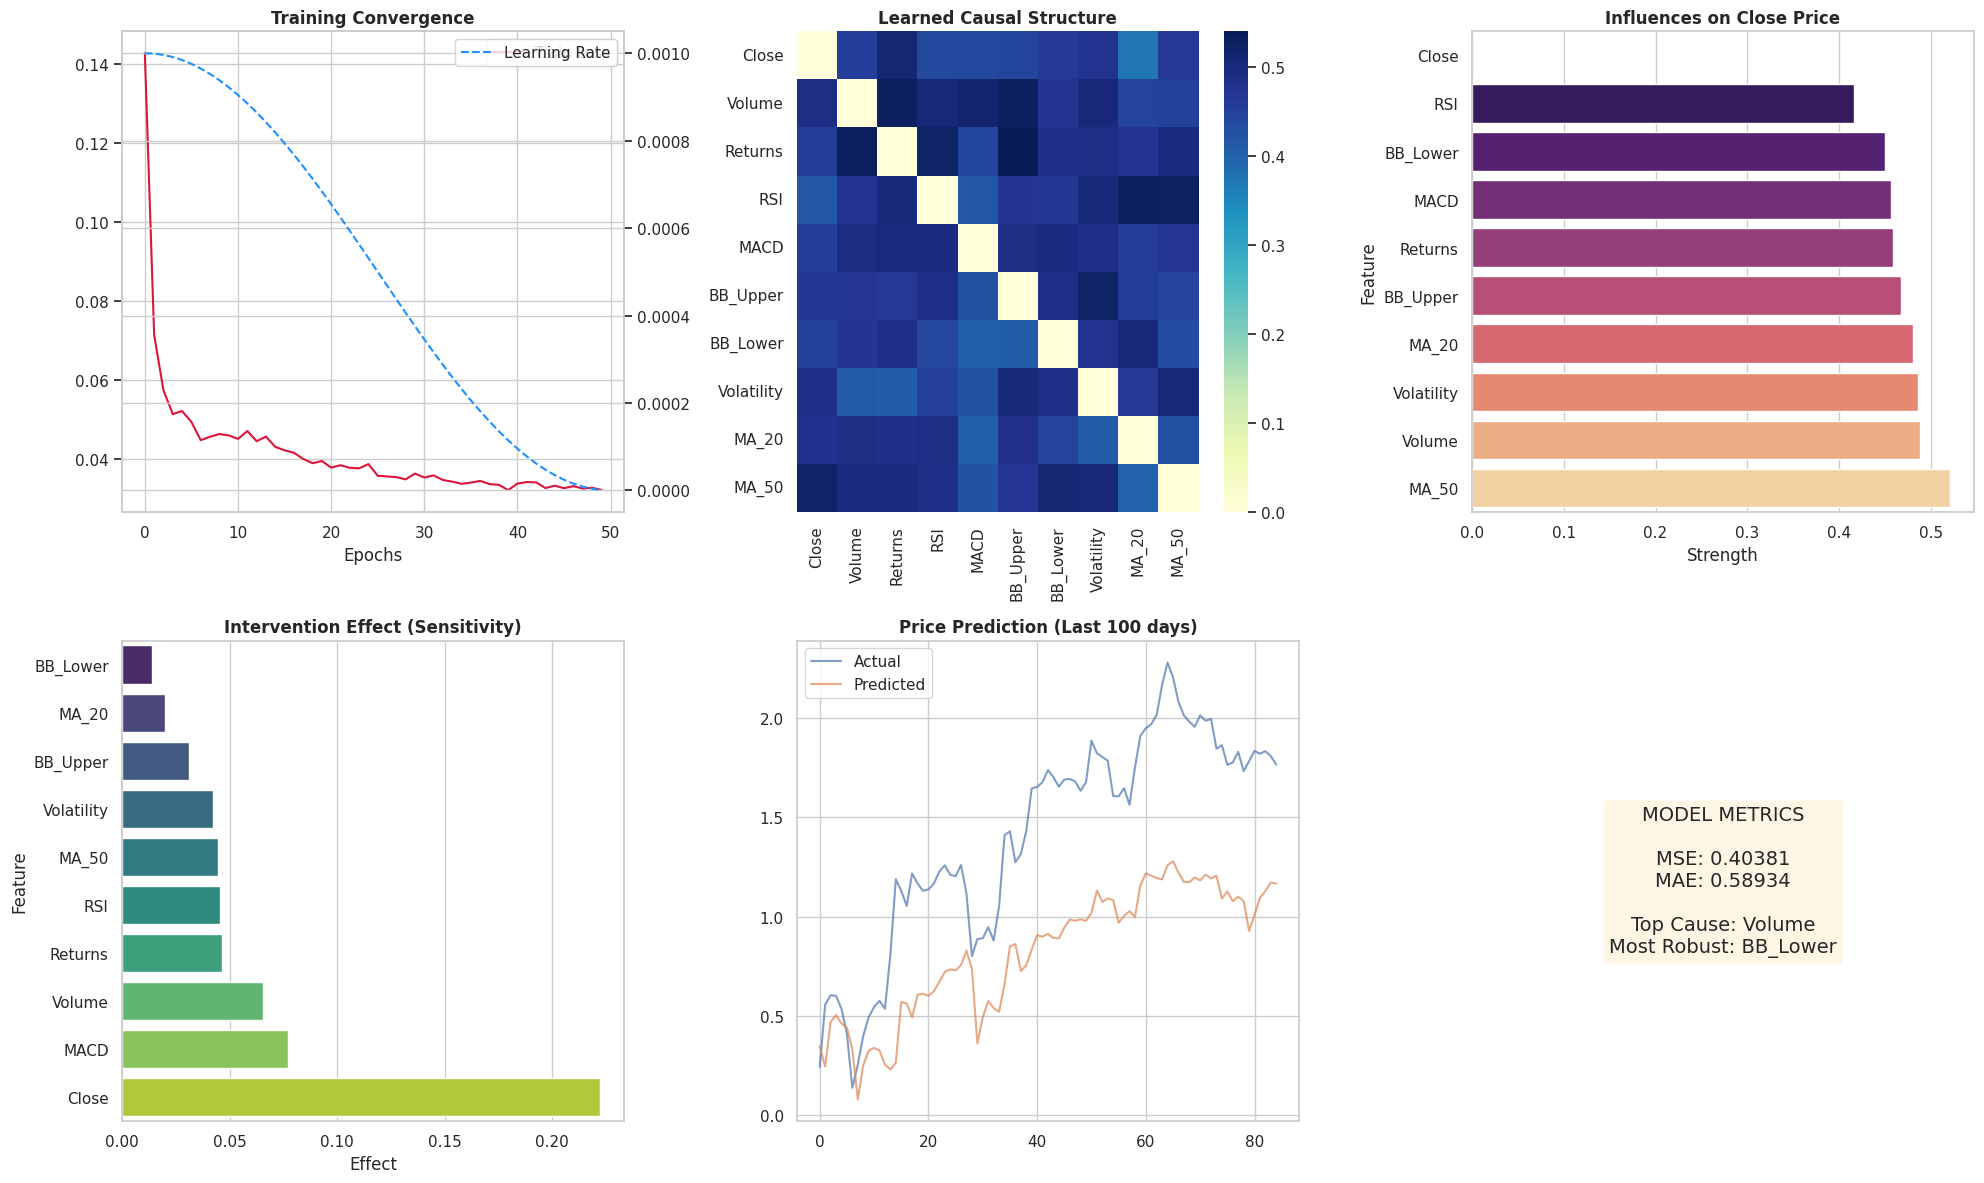

In [4]:
# --- BLOCK 4: PROFESSIONAL VISUALIZATION ---
def plot_advanced_metrics(predictor, history, X_test, y_test, features):
    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(20, 12))

    # 1. Lịch sử huấn luyện (Loss & LR)
    plt.subplot(2, 3, 1)
    ax1 = sns.lineplot(x=range(len(history['loss'])), y=history['loss'], color='crimson', label='Train Loss')
    plt.title('Training Convergence', fontweight='bold')
    ax2 = ax1.twinx()
    sns.lineplot(x=range(len(history['lr'])), y=history['lr'], color='dodgerblue', linestyle='--', ax=ax2, label='Learning Rate')
    ax1.set_xlabel('Epochs')

    # 2. Causal Heatmap
    plt.subplot(2, 3, 2)
    adj = predictor.model.causal_discovery.get_causal_adjacency().detach().cpu().numpy()
    sns.heatmap(adj, xticklabels=features, yticklabels=features, cmap='YlGnBu', annot=False)
    plt.title('Learned Causal Structure', fontweight='bold')

    # 3. Top Causal Influences on 'Close'
    plt.subplot(2, 3, 3)
    close_idx = features.index('Close')
    influences = adj[:, close_idx]
    inf_df = pd.DataFrame({'Feature': features, 'Strength': influences}).sort_values('Strength')
    sns.barplot(data=inf_df, x='Strength', y='Feature', palette='magma')
    plt.title('Influences on Close Price', fontweight='bold')

    # 4. Intervention Robustness
    plt.subplot(2, 3, 4)
    robustness = predictor.test_intervention_robustness(X_test)
    rob_df = pd.DataFrame(list(robustness.items()), columns=['Feature', 'Effect']).sort_values('Effect')
    sns.barplot(data=rob_df, x='Effect', y='Feature', palette='viridis')
    plt.title('Intervention Effect (Sensitivity)', fontweight='bold')

    # 5. Prediction Accuracy
    plt.subplot(2, 3, 5)
    test_res = predictor.predict(X_test)
    preds = test_res['predictions'].flatten()
    actual = y_test.flatten()
    plt.plot(actual[:100], label='Actual', alpha=0.7)
    plt.plot(preds[:100], label='Predicted', alpha=0.7)
    plt.legend()
    plt.title('Price Prediction (Last 100 days)', fontweight='bold')

    # 6. Tóm tắt kết quả
    plt.subplot(2, 3, 6)
    plt.axis('off')
    mse = np.mean((preds - actual)**2)
    mae = np.mean(np.abs(preds - actual))
    summary = f"MODEL METRICS\n\nMSE: {mse:.5f}\nMAE: {mae:.5f}\n\nTop Cause: {inf_df.iloc[-2]['Feature']}\nMost Robust: {rob_df.iloc[0]['Feature']}"
    plt.text(0.5, 0.5, summary, ha='center', va='center', fontsize=14, bbox=dict(facecolor='orange', alpha=0.1))

    plt.tight_layout()
    plt.savefig('full_model_analysis.png', dpi=300)
    plt.show()

# Thực thi vẽ biểu đồ
plot_advanced_metrics(predictor, history, X_test, y_test, features)

MODIFY WITH ATTENTION-GUIDED CAUSAL